# Kunskapskontroll

Målet med denna script är att ta reda på om det finns en löneskillnad mellan män och kvinnor, i AdventureWorks, för samma jobb.

In [17]:
#!pip install sqlalchemy 
print ('it is librariy to provide tools for managing connectivity to database ')
 
#!pip install pyodbc
print ('its another library to it working as pro between salalchemy and database ')
from sqlalchemy import create_engine
print ('vi importerat from SQLAlchemy : engin , matadata table , inspect ')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

it is librariy to provide tools for managing connectivity to database 
its another library to it working as pro between salalchemy and database 
vi importerat from SQLAlchemy : engin , matadata table , inspect 


In [18]:
import pandas as pd
from sqlalchemy import create_engine

database = "AdventureWorks2022"
host = "MSI"

connection_string = f"mssql://{host}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
engine = create_engine(connection_string)


In [19]:
# Vi behöver en lista över anställda där vi bara bryr oss om tjänstetiteln, könet och lönegraden

salaries_query = """
SELECT   
  HR.JobTitle,
  HR.Gender,
  EmpPay.Rate
FROM HumanResources.Employee AS HR 
INNER JOIN HumanResources.EmployeePayHistory AS EmpPay
    ON EmpPay.BusinessEntityID = HR.BusinessEntityID
"""

In [20]:
# Med hjälp av anslutningen hämtar vi data från SQL Server
salaries = pd.read_sql(salaries_query, con=connection)

In [21]:
# vi vill behålla jobbtitlar som innehåller män och kvinnor
# givet en uppsättning kön vill vi att den ska ha längd 2 (M och F)
# När vi väl vet vilka jobb som har män och kvinnor utesluter vi de andra

job_has_men_and_women = lambda group: len(group) == 2

jobs_with_m_and_f = salaries.groupby('JobTitle')['Gender'].agg(set)
jobs_with_m_and_f = jobs_with_m_and_f[jobs_with_m_and_f.apply(job_has_men_and_women)]

salaries = salaries[salaries['JobTitle'].isin(jobs_with_m_and_f.index)]
salaries

,JobTitle,Gender,Rate
6,Design Engineer,F,32.6923
7,Design Engineer,M,32.6923
13,Tool Designer,M,25.0000
14,Tool Designer,F,25.0000
16,Design Engineer,F,32.6923
...,...,...,...
309,Sales Representative,M,23.0769
311,Sales Representative,F,23.0769
313,Sales Representative,F,23.0769
314,Sales Representative,F,23.0769


In [22]:
# Beräkna konfidensintervall för medellönen, oavsett befattning

ci = stats.norm.interval(0.95, loc=np.mean(salaries.Rate), scale=stats.sem(salaries.Rate))
print(f"Confidence Interval for Average Salary: {ci}")

Confidence Interval for Average Salary: (13.62929456142581, 15.024576170281508)


In [23]:
# Nu tar vi medellönen efter tjänstetitel och kön, så för en given tjänstetitel får vi två genomsnitt (en för kvinnor, en för män)
salaries_mean = salaries.groupby(['JobTitle', 'Gender']).mean()
salaries_mean

Rate
JobTitle                       Gender           
Accountant                     F       26.442300
                               M       26.442300
Accounts Payable Specialist    F       19.000000
                               M       19.000000
Accounts Receivable Specialist F       19.000000
                               M       19.000000
Application Specialist         F       27.403800
                               M       27.403800
Buyer                          F       18.269200
                               M       18.269200
Design Engineer                F       32.692300
                               M       32.692300
Document Control Assistant     F       10.250000
                               M       10.250000
Janitor                        F        9.250000
                               M        9.250000
Marketing Assistant            F       13.461500
                               M       13.461500
Marketing Specialist           F       14.423100
                               M       14.423100
Production Supervisor - WC20   F       25.000000
                               M       25.000000
Production Supervisor - WC30   F       25.000000
                               M       25.000000
Production Supervisor - WC40   F       25.000000
                               M       25.000000
Production Supervisor - WC45   F       25.000000
                               M       25.000000
Production Supervisor - WC60   F       25.000000
                               M       25.000000
Production Technician - WC10   F       13.450000
                               M       13.450000
Production Technician - WC20   F       14.000000
                               M       14.000000
Production Technician - WC30   F        9.500000
                               M        8.333333
Production Technician - WC40   F       15.000000
                               M       15.000000
Production Technician - WC45   F       10.000000
                               M       10.000000
Production Technician - WC50   F       11.000000
                               M       11.000000
Production Technician - WC60   F       12.450000
                               M       12.450000
Purchasing Assistant           F       12.750000
                               M       12.750000
Sales Representative           F       23.076900
                               M       23.076900
Stocker                        F        9.000000
                               M        9.000000
Tool Designer                  F       25.000000
                               M       25.000000

In [24]:
# Nu när vi har båda medelvärdena kan vi införa en ny kolumn som kommer att innehålla skillnaden mellan medelvärdena
# Låt oss välja män som minuend, så positiva skillnader betyder "män får mer" och negativa betyder "kvinnor får mer"
# För enkelhetens skull kan vi avrunda till 4 siffror

salaries_mean_diff = salaries_mean.pivot_table(index='JobTitle', columns= 'Gender', values = 'Rate')
salaries_mean_diff['RateDifference'] = round((salaries_mean_diff['M'] - salaries_mean_diff['F']), ndigits=4)
salaries_mean_diff

Gender,F,M,RateDifference
JobTitle,,,
Accountant,26.4423,26.442300,0.0000
Accounts Payable Specialist,19.0000,19.000000,0.0000
Accounts Receivable Specialist,19.0000,19.000000,0.0000
Application Specialist,27.4038,27.403800,0.0000
Buyer,18.2692,18.269200,0.0000
Design Engineer,32.6923,32.692300,0.0000
Document Control Assistant,10.2500,10.250000,0.0000
Janitor,9.2500,9.250000,0.0000
Marketing Assistant,13.4615,13.461500,0.0000


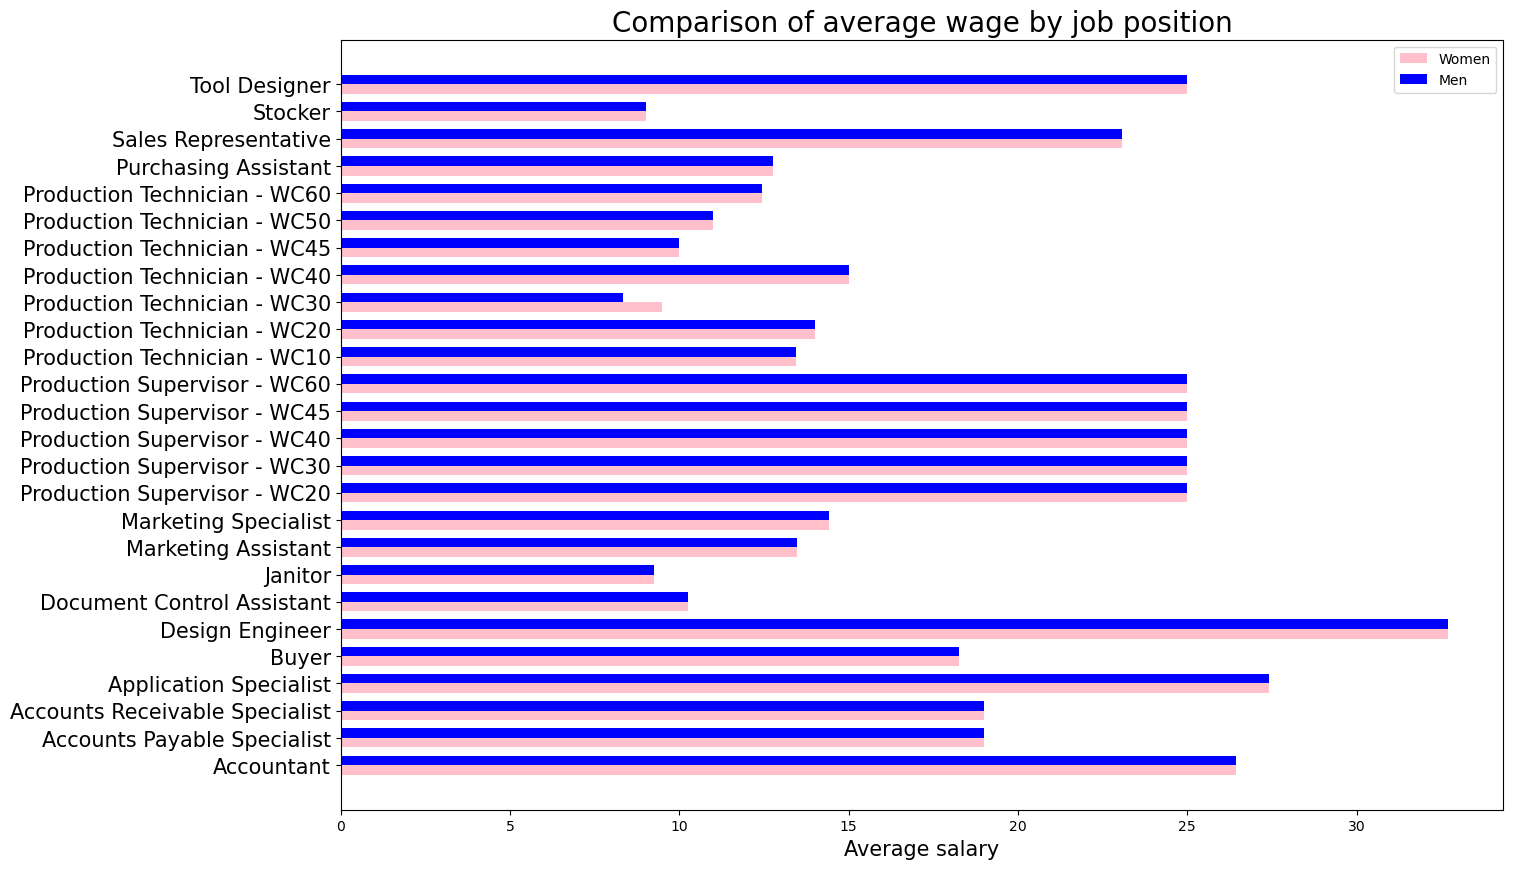

In [25]:
# Låt oss rita båda medelvärdena
# Ställa in positioner och bredd för stängerna
categories = salaries_mean_diff['F'].index
pos = np.arange(len(categories))
width = 0.35

plt.figure (figsize=(15,10))

# Plotta kvinnors genomsnittliga lön
plt.barh(pos - width/2, salaries_mean_diff['F'], width, label='Women', color='pink')

# Plotta män genomsnittlig lön
plt.barh(pos + width/2, salaries_mean_diff['M'], width, label='Men', color='blue')

# Lägga till etiketter och titel
plt.title('Comparison of average wage by job position', fontsize=20)
plt.xlabel('Average salary', fontsize=15)
plt.yticks(pos, categories, fontsize=15)

# Lägger till legend
plt.legend()

# Visa handlingen
plt.show()

Som det visas i stapeldiagrammet hittade vi bara för "Product Technician - WC30" ett löneskillnad, men i det här fallet är det kvinnor som tjänar mer. Det skulle vara trevligt i framtiden att ytterligare undersöka denna lilla lucka.

Det ser ut som att AdventureWorks är ett företag som inte diskriminerar baserat på kön